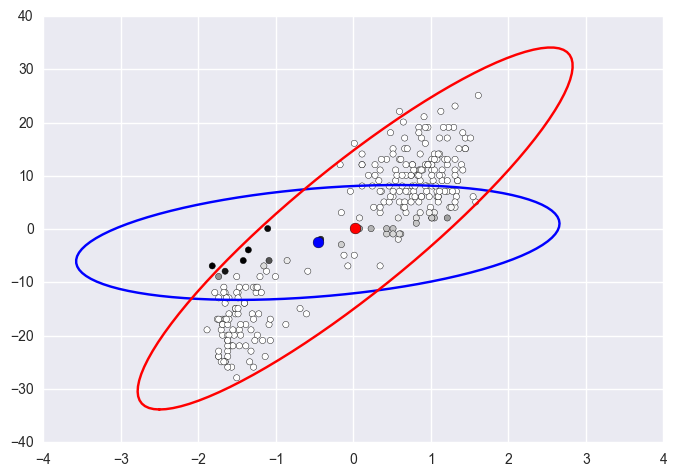

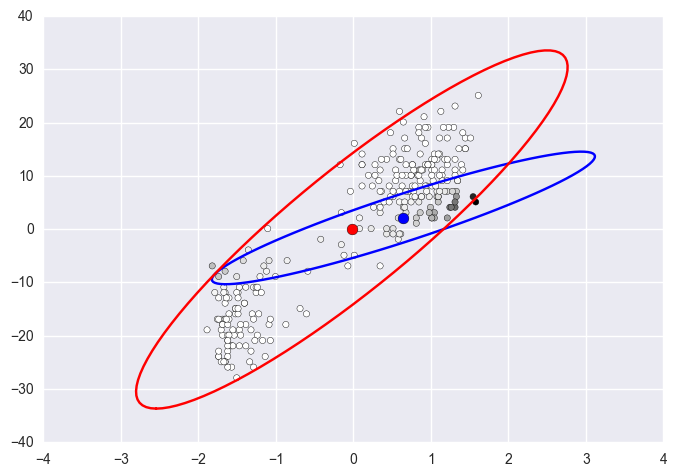

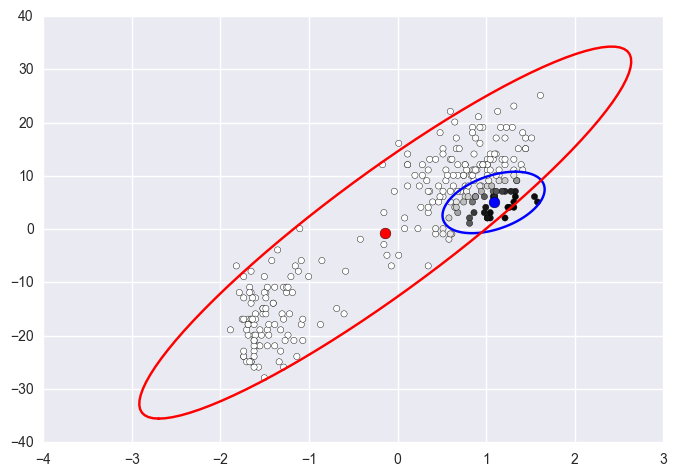

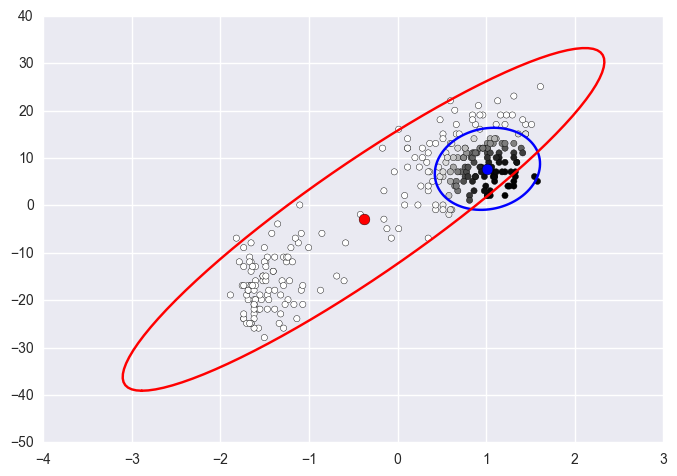

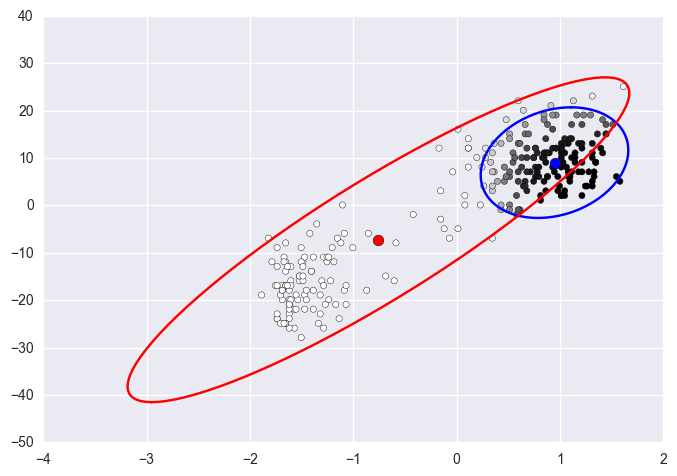

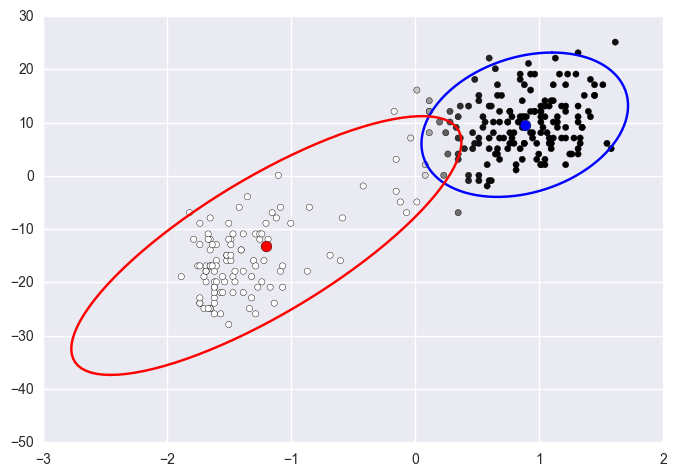

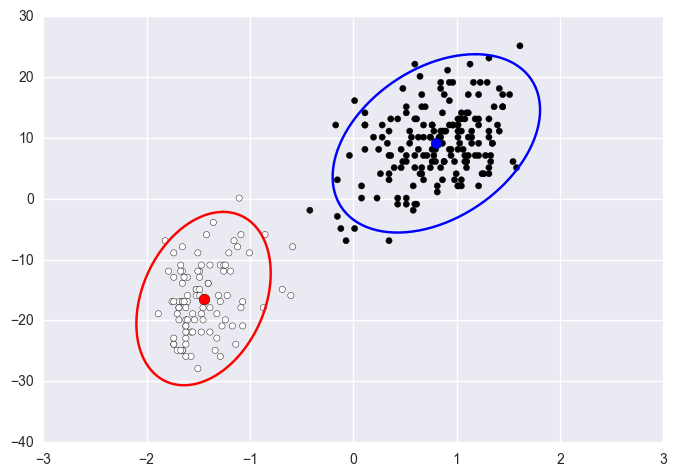

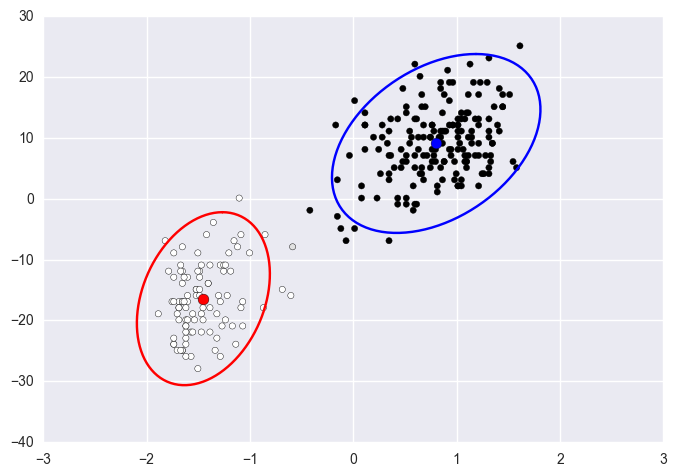

In [3]:
import numpy as np
import scipy.io
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
 
# Takes the covariance and gives back points to create an ellipse 
# around the 95% confidence interval
def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )



# upload the data  
data_mat = scipy.io.loadmat('old_faithful.mat')
data = data_mat['data']


datasize = data[:,0].size

# meancenter the data
#Find the mean of the x and y data
mean0 = np.mean(data[:,0])
mean1 = np.mean(data[:,1])

#Then subtract the means from each x and y point
meancentered = np.zeros((datasize, 2))
for i in xrange(datasize):
    meancentered[i,0] = data[i,0]-mean0
    meancentered[i,1] = data[i,1]-mean1
    

    

# the Gaussian means (as column vectors -- ie, the mean for Gaussian 0 is mus[:,0]
mus = np.asarray( [[-1.17288986, -0.11642103],
                   [-0.16526981,  0.70142713]])
 
# the Gaussian covariance matrices
covs = list()
covs.append( 
    np.asarray([[ 0.74072815,  0.09252716],
                [ 0.09252716,  0.5966275 ]]) )
covs.append( 
    np.asarray([[ 0.39312776, -0.46488887],
                [-0.46488887,  1.64990767]]) )
 
# The Gaussian mixing weights
mws = [ 0.68618439, 0.31381561 ]  # called alpha in the slides

wik = []
for i in xrange(40):
    mus, mws, covs, wik0 = gmm(mus, covs, mws)
    if (i%5 == 0):
        plotit(mus, mws, covs, wik)
        


In [1]:
def gmm(mus, covs, mws):
    # Compute the responsibilities rik (weights) x
    # Update the mixing weights πk 
    # Update the covariances Σk  x
    # Update the means μk 

    # compute the likelihood of a multivariate Gaussian
    multigaus0 = scipy.stats.multivariate_normal.pdf(meancentered, mus[:,0], covs[0])
    multigaus1 = scipy.stats.multivariate_normal.pdf(meancentered, mus[:,1], covs[1])

    numerator0 = multigaus0 * mws[0]
    numerator1 = multigaus1 * mws[1]
    denom = numerator0 + numerator1

    wik0 = numerator0/denom
    wik1 = numerator1/denom

    #The Nk is the sum of all the wiks for each k
    N0= np.sum(wik0)
    N1 = np.sum(wik1)

    #Find the mixing weights
    mw0 = N0/datasize
    mw1 = N1/datasize

    #Find the sum of points to normalize with
    norm0 = 1.0/N0
    norm1 = 1.0/N1

    # sigmanew = sum of the mixing weights*dot product of (xi-uk)^2
    sumestimate0 = np.zeros((2,2))
    sumestimate1 = np.zeros((2,2))
    for i in xrange(datasize):
        innermatrix0 = np.atleast_2d(meancentered[i]-mus[:,0])
        innermatrix1 = np.atleast_2d(meancentered[i]-mus[:,1])
        dotproduct0 = np.dot(innermatrix0.T,innermatrix0)
        dotproduct1 = np.dot(innermatrix1.T,innermatrix1)
        sumestimate0 += wik0[i]*dotproduct0 
        sumestimate1 += wik1[i]*dotproduct1
    sig_new0 = norm0 * sumestimate0
    sig_new1 = norm1 * sumestimate1


    # Set the new mu
    summu = np.zeros((2,2))
    for i in xrange(datasize):
        summu[0] += wik0[i]*meancentered[i]
        summu[1] += wik1[i]*meancentered[i]

    summu[0] = summu[0]*norm0
    summu[1] = summu[1]*norm1
    summu = summu.T

    # Reset the naming conventions from before for convenience
    covs[0] = sig_new0
    covs[1] = sig_new1
    mus = summu
    mws[0] = mw0
    mws[1] = mw1
    
    return mus, mws, covs, wik0

In [2]:
def plotit(mus, mws, covs, wik):
    # scatters a set of points; check out the "c" keyword argument to change color, and the "s" arg to change the size
    # plt.scatter(data[:,0],data[:,1], c = 'white')
    plt.scatter(meancentered[:,0],meancentered[:,1], c = wik0)
    plt.scatter(mus[0,0], mus[1,0],c = 'blue', s = 60 )
    plt.scatter(mus[0,1], mus[1,1],c = 'red', s = 60 )
    covpts0 = cov_to_pts( covs[0] )
    covpts1 = cov_to_pts( covs[1] )
    plt.plot(covpts0[0]+mus[0,0],covpts0[1]+mus[1,0], c = 'blue')
    plt.plot(covpts1[0]+mus[0,1],covpts1[1]+mus[1,1], c = 'red')
    #plt.xlim ((-5,5))# sets the range of values for the x axis
    # plt.ylim # sets the range of values for the y axis
    plt.show()